Triple Point Collocation Use Case
Monthly, L3 SMAP, SMOS, and Argo data

j. anderson (janderson@esr.org)

In [2]:
# Import packages
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import fnmatch
import netCDF4 as nc
from dateutil.relativedelta import relativedelta
import xesmf as xe
from cartopy import crs as ccrs

In [3]:
#from covariance_triple_point_collocation import * #to call covariance_triple_point_collocation from outside notebook

In [4]:
def covariance_triple_point_collocation(data1, data2, data3, flag):
# Basic Triple Point Collocation Analysis for any combination of datasets
# Input datasets must be 2D with dimensions 1xN, Mx1, or MXN 
# All datasets must have uniform dimensions 
# Flag: 1 = exclude large dataset differences abs(>5PSU) from analysis, 0=include all dataset differences regardless of size

# J. Anderson (janderson@esr.org) based on Stoffelen 1998 & Gruber et al 2016 Covariance Notation 
    
# Error check input data for uniform dimensions and valid flag value
# Python automaticaly checks that the correct numbe of imputs were given
    num = ((data1.shape == data2.shape)+(data1.shape == data3.shape)+(data2.shape == data3.shape))
    
    if num != 3:
        raise Exception('Input datasets must have uniform dimensions')

    if np.isin(flag,[0,1]) == False:
        raise Exception('Flag input must be 1 or 0')
        
    # Flatten data prior to triple point collocation analysis
    data1 = np.ravel(data1)
    data2 = np.ravel(data2)
    data3 = np.ravel(data3)
        
    # Prepare data for triple point collocation
    # If flag = 1, remove data where absolute value of differences > 5 PSU
    if flag == 1:
        
        #'Data1 - Data3'
        ds_d1_d3 = data1-data3; # Calculate the difference between Data1 & Data3
        tempLarge = np.where(np.absolute(ds_d1_d3)>5)
        data1[tempLarge]='NaN'
        data3[tempLarge]='NaN'
        del tempLarge, ds_d1_d3
        
        #'Data2 - Data3'
        ds_d2_d3 = data2-data3; # Calculate the difference between Data1 & Data3
        tempLarge = np.where(np.absolute(ds_d2_d3)>5)
        data2[tempLarge]='NaN'
        data3[tempLarge]='NaN'
        del tempLarge, ds_d2_d3

        #'Data1 - Data2'
        ds_d1_d2 = data1-data2; # Calculate the difference between Data1 & Data3
        tempLarge = np.where(np.absolute(ds_d1_d2)>5)
        data1[tempLarge]='NaN'
        data2[tempLarge]='NaN'
        del tempLarge, ds_d1_d2
    
    # Triple point collocation cannot be calculated if one dataset has a NaN. 
    # Make location of NaNs uniform for all datasets. 
    data2[np.argwhere(np.isnan(data1))]='NaN'
    data3[np.argwhere(np.isnan(data1))]='NaN'

    data1[np.argwhere(np.isnan(data2))]='NaN'
    data3[np.argwhere(np.isnan(data2))]='NaN'

    data1[np.argwhere(np.isnan(data3))]='NaN'
    data2[np.argwhere(np.isnan(data3))]='NaN'
    
    # Start triple point collocation
    # Calculate variance of each dataset
    var_d1 = np.nanvar(data1,ddof=1) # Variance computed on flattened variance
    var_d2 = np.nanvar(data2,ddof=1)
    var_d3 = np.nanvar(data3,ddof=1)

    # Calculate the covariance of Data1 and Data3
    covar_d1_d3 = np.diagonal(ma.cov(ma.array(data1, mask=np.isnan(data1)), ma.array(data3, mask = np.isnan(data3)),ddof=1),offset=1) # covariance of data1 and data3 is off diagonal element, masked to ignore nans

    # Calculate the covariance of Data2 and Data3
    covar_d2_d3 = np.diagonal(ma.cov(ma.array(data2, mask=np.isnan(data2)), ma.array(data3, mask = np.isnan(data3)),ddof=1),offset=1) # covariance of data2 and data3 is off diagonal element, masked to ignore nans

    # Calculate the covariance of Data1 and Data2
    covar_d1_d2 = np.diagonal(ma.cov(ma.array(data1, mask=np.isnan(data1)), ma.array(data2, mask = np.isnan(data2)),ddof=1),offset=1) # covariance of data1 and data2 is off diagonal element, masked to ignore nans
    
    # Calculate the unscaled error variances for each dataset
    # Covariance is symmetrical, so cov(d1,d2)==cov(d2,d1)
    errorvar_d1 = (var_d1-((covar_d1_d2*covar_d1_d3)/covar_d2_d3))
    errorvar_d2 = (var_d2-((covar_d1_d2*covar_d2_d3)/covar_d1_d3))
    errorvar_d3 = (var_d3-((covar_d1_d3*covar_d2_d3)/covar_d1_d2))

    # Determine rescaling parameters if desired
    # Rescale to d1
    #rescale_d2 = (covar_d1_d3/covar_d2_d3)
    #rescale_d3 = (covar_d1_d2/covar_d2_d3)

    #errorvar_d1 = errorvar_d1
    #errorvar_d2 = errorvar_d2*(rescale_d2**2)
    #errorvar_d3 = errorvar_d3*(rescale_d3**2)

    # Calculate RMSD from the unscaled error variances
    rmsd_d1 = np.sqrt(errorvar_d1);
    rmsd_d2 = np.sqrt(errorvar_d2);
    rmsd_d3 = np.sqrt(errorvar_d3);
    
    # It is possible to have negative unscaled variances which means imaginary rmsd. Only keep positive variances, real rmsd.
    # Replace imaginary numbers with NaN
    # NumPy sqrt only returns sqrts for positive values, replace masked, invalid numbers with NaN
    rmsd_d1 = rmsd_d1.filled(np.nan)
    rmsd_d2 = rmsd_d2.filled(np.nan)
    rmsd_d3 = rmsd_d3.filled(np.nan)
    
    return [rmsd_d1,rmsd_d2,rmsd_d3]

In [5]:
# Define variables -- all user defined variables here

# Output directory, Local
outputDir = os.path.join(os.sep, 'Users','jesse','Documents','ESR','PiMEP','Data','TriplePointCollocation') #This method uses correct seperator for operating system
print(outputDir)

# Input data directories, Local
smosDir = os.path.join(os.sep, 'Volumes','T7','ESR','Datasets','SMOS','SMOS_SSS_L3_v317_CATDS_CPDC','Ocean_products','GRIDDED','MonthlyOnly'); # location of smos data
smapDir = os.path.join(os.sep, 'Volumes','T7','ESR','Datasets','SMAP','L3','RSS','V4','monthly','SCI','AllData'); # location of smap data
argoDir = os.path.join(os.sep, 'Volumes','T7','ESR','Datasets','Argo','RG_ArgoClimatology'); # location of argo data

print(smosDir)
print(smapDir)
print(argoDir)

# Date to start and end analysis
# PiMEP integration should have error checking for valid dates for each dataset
startDate = '4-1-2015'; # For this use case, SMAP has the latest start of 1 April 2015
endDate = '1-31-2022'; # Use case maximum date 1-31-2022

# Set large difference flag
excludeLargeDiff = 1; #1 (true) yes exclude large difference (>5PSU), 0 for no, include all salinity data differences regardless of size

# ---------End User Inputs--------------

# Parse inputs

# Convert user input date time to python datetime format
startDate = datetime.strptime(startDate,'%m-%d-%Y')
endDate = datetime.strptime(endDate,'%m-%d-%Y')

# Determine how many months to run analysis
numMonths2 = (endDate.year-startDate.year)*12+(endDate.month-startDate.month)+1
print(numMonths2)

# Create list of month/year combinations
dateList = pd.date_range(startDate,endDate,freq='MS')
print(dateList)



/Users/jesse/Documents/ESR/PiMEP/Data/TriplePointCollocation
/Volumes/T7/ESR/Datasets/SMOS/SMOS_SSS_L3_v317_CATDS_CPDC/Ocean_products/GRIDDED/MonthlyOnly
/Volumes/T7/ESR/Datasets/SMAP/L3/RSS/V4/monthly/SCI/AllData
/Volumes/T7/ESR/Datasets/Argo/RG_ArgoClimatology
82
DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-

# Load SMOS

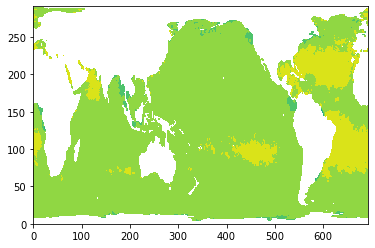

In [6]:
# Load First Dataset - SMOS

# Go to location of SMOS data
os.chdir(smosDir)

# Get list of all data files
tempFileList = [] # initalize filelist variable
for (root, dirs, files) in os.walk(smosDir): 
        for filename in fnmatch.filter(files, 'SM_RE07*.nc'): #Get information on all delayed mode files in directory 
            tempFileList.append(filename) # Keep only the filenames

for (root, dirs, files) in os.walk(smosDir): 
        for filename in fnmatch.filter(files, 'SM_OPER*.nc'): #Get information on all operational data files in directory
            tempFileList.append(filename) # Keep only the filenames and add to end of file list
#print(tempFileList)

# Read in static variables from first file
fnTemp = tempFileList[0] # get first filename
dsTemp = nc.Dataset(fnTemp,'r')
# Lon: 694x1 degrees_east -179.8703 to 179.6109 0.5187 degree FillValue = 9.969209968386869e+36
# Lat: 292x1 degrees_north -83.5171 81.9831 0.3923-2.8199 FillValue = 9.969209968386869e+36
smosLon, smosLat = np.array(dsTemp.variables['lon']), np.array(dsTemp.variables['lat'])
dsTemp.close()
del fnTemp

# Initialize and preallocate dynamic variables with matrices of NaNs
smosDateTime = np.empty((len(tempFileList),1),dtype='datetime64[s]') #nan(size(tempFileList,1),1);
smosDateTime[:] = np.datetime64("NaT")
smosS = np.empty((len(smosLon),len(smosLat),len(tempFileList)))#nan(length(smosLon), length(smosLat),size(tempFileList,1));
smosS[:] = np.NaN

# Load and write data from monthly files to dynamic variables
for fileLoop in range(len(tempFileList)): # in this case fileLoop has loop count number
    fnTemp = tempFileList[fileLoop] 
    #print(fnTemp)

    # Get date and time from filename
    smosDateTime[fileLoop] = datetime.strptime('-'.join([fnTemp[19:23],fnTemp[23:25],fnTemp[25:27],\
                                        fnTemp[28:30],fnTemp[30:32],fnTemp[32:34]]),'%Y-%m-%d-%H-%M-%S')
    
    # Get salinity data
    dsTemp = nc.Dataset(fnTemp,'r')

    smosS[:,:,fileLoop] = np.transpose(dsTemp.variables['Mean_Sea_Surface_Salinity_1']); # 694x292 lon, lat 'Mean sea surface salinity' FillValue = -32767 PSU add_offset = 30 scale_factor = 0.001
    #smosS[:,:,fileLoop] = np.transpose(dsTemp.variables['Mean_Sea_Surface_Salinity_2']); # 694x292 lon, lat 'Mean sea surface salinity (rain corrected)' FillValue = -32767 PSU add_offset = 30 scale_factor = 0.001
    
    dsTemp.close()
    del fnTemp

del tempFileList 
del fileLoop
#print(smosS[120,120,:])

# Prepare SMOS data for analysis

# Replace fill values with NaN
smosS[smosS==-32767]=np.nan

# Quick plot to ensure looks right
#tp = plt.contourf(np.transpose(smosS[:,:,0]))
#plt.show(tp)

# Standardize Lat - 90 to 90
#print(min(smosLat)) # -83.5171 0.3923-2.8199 degree spacing
#print(max(smosLat)) # 81.9831
#print(min(np.diff(smosLat)))
#print(max(np.diff(smosLat)))

# Standardize Lon 0 to 360
#print(min(smosLon)) #  -179.8703 0.5187 degree spacing
#print(max(smosLon)) # 179.6109
#print(min(np.diff(smosLon)))
#print(max(np.diff(smosLon)))

# Adjust longitude values to be 0-360 degrees
tempIndex = np.where(smosLon<0)
smosLon[tempIndex] = smosLon[tempIndex]+360
del tempIndex

# Sort adjusted longitude values and corresponding SMOS salinity data
tempIndex = np.argsort(smosLon)
smosLon = smosLon[tempIndex]
smosS= smosS[tempIndex,:,:]
del tempIndex

# Quick plot to ensure looks right
tr = plt.contourf(np.transpose(smosS[:,:,0]))
plt.show(tr)

# Remove data outside month/year range of run
tempIndex = np.where(smosDateTime < startDate)
smosDateTime=np.delete(smosDateTime,tempIndex,axis=0)
smosS=np.delete(smosS,tempIndex,axis=2)
del tempIndex

tempIndex = np.where(smosDateTime > endDate)
smosDateTime=np.delete(smosDateTime,tempIndex,axis=0)
smosS=np.delete(smosS,tempIndex,axis=2)
del tempIndex

# Load SMAP

['Filename RSS_smap_SSS_L3_monthly_2019_07_FNL_v04.0.ncdoes not exist']


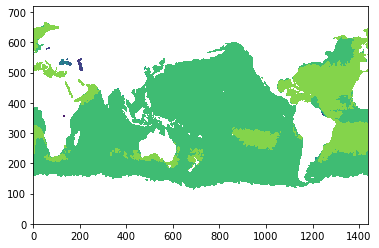

In [7]:
# Load Second Dataset  - SMAP 70km

# Go to location of SMAP data
os.chdir(smapDir)

# Create list of data files over processing time period
tempFileList = np.tile('RSS_smap_SSS_L3_monthly_'+dateList.strftime("%Y")+'_'+dateList.strftime("%m")+'_FNL_v04.0.nc',1)

# Determine if all the data file names created exist in directory
tempFileExist=[]
for tempFileName in tempFileList: #Get information on all delayed mode files in directory 
    tempFileExist.append(os.path.exists(tempFileName)) # Keep only the filenames
del tempFileName

tempTrueIndex = [i for i, val in enumerate(tempFileExist) if val]
if np.sum(tempTrueIndex) == 0:
    raise Exception('None of the filenames created exist in the current directory')
    
# Read in static variables from first file that exists
tempFileIndex = np.argmin(tempTrueIndex) # Find index of first file that exists
fnTemp = tempFileList[tempFileIndex] # get first filename
dsTemp = nc.Dataset(fnTemp,'r')
#Lon: 1440x1 center longitude of grid cell degrees east 0.125 359.875 0.25 degree
#Lat: 720x1 center latitude of grid cell degrees_north -89.875 89.875 0.25 degree
smapLon, smapLat = np.array(dsTemp.variables['lon']), np.array(dsTemp.variables['lat'])
dsTemp.close()
del fnTemp
del tempFileIndex 

# Initialize and preallocate dynamic variables with matrices of NaNs
smapTime = np.empty((len(tempFileList),1),dtype='datetime64[s]') # 1x1 seconds since 2000-01-01T00:00:00Z reference time of analyzed variable field corresponding to center of the product time interval
smapTime[:]=np.datetime64("NaT")
smapS =  np.empty((len(smapLon),len(smapLat),len(tempFileList)))#nan(length(smapLon), length(smapLat),size(tempFileList,1)) # 1440x720 lon, lat sea_surface_salinity -9999 fill
smapS[:] = np.NaN
smapGland = np.empty((len(smapLon),len(smapLat),len(tempFileList))) #1440x720 lon, lat Average land fraction weighted by antenna gain -9999 fill # 1440x720 lon, lat sea_surface_salinity -9999 fill
smapFland = np.empty((len(smapLon),len(smapLat),len(tempFileList))) #1440x720 lon, lat  Average land fraction within 3dB contour -9999 fill
smapGice = np.empty((len(smapLon),len(smapLat),len(tempFileList))) #1440x720 lon, lat Average sea ice fraction (weighted by antenna gain) -9999 fill
smapSurtep = np.empty((len(smapLon),len(smapLat),len(tempFileList))) #1440x720 lon, lat sea_surface_temperature -9999 fill

# Load and write data from monthly files to dynamic variables
for fileLoop in range(len(tempFileList)): # in this case fileLoop has loop count number
    if tempFileExist[fileLoop] == True: # If the file exists read in data
        fnTemp = tempFileList[fileLoop] 
        #print (fnTemp)
        dsTemp = nc.Dataset(fnTemp,'r')
        
        # Read in and convert SMAP time to datetime
        # smapTime is seconds since seconds since 2000-01-01T 00:00:00Z
        # smapTime is centered roughly on 15th of month
        smapTime[fileLoop] = np.transpose(nc.num2date(dsTemp['time'][:], dsTemp['time'].units)) #1x1 seconds since 2000-01-01T00:00:00Z reference time of analyzed variable field corresponding to center of the product time interval
        
        # Read in salinity data and data flags
        smapS[:,:,fileLoop]  = np.transpose(dsTemp.variables['sss_smap']) #1440x720 lon, lat sea_surface_salinity -9999 fill
        smapGland[:,:,fileLoop] = np.transpose(dsTemp.variables['gland']) #1440x720 lon, lat Average land fraction weighted by antenna gain -9999 fill
        smapFland[:,:,fileLoop] = np.transpose(dsTemp.variables['fland']) #1440x720 lon, lat  Average land fraction within 3dB contour -9999 fill
        smapGice[:,:,fileLoop] = np.transpose(dsTemp.variables['gice']) #1440x720 lon, lat Average sea ice fraction (weighted by antenna gain) -9999 fill
        smapSurtep[:,:,fileLoop] = np.transpose(dsTemp.variables['surtep']) #1440x720 lon, lat sea_surface_temperature -9999 fill

        dsTemp.close()
        del fnTemp
    else:
        print(['Filename '+tempFileList[fileLoop]+'does not exist']) #If file doesn't exist, do nothing. Already filled with nans from preallocation

del tempFileList
del fileLoop
del tempFileExist

smapDateTime = smapTime
del smapTime

# Replace fill values with NaN
smapS[smapS==-9999]=np.nan
smapGland[smapGland==-9999]=np.nan
smapFland[smapFland==-9999]=np.nan
smapGice[smapGice==-9999]=np.nan
smapSurtep[smapSurtep==-9999]=np.nan

# Remove salinity data near land, near ice, cold SST region using thresholds provided with dataset
#  land_ice_exclusions = 'discard observations if land or seaice fraction exceeds threshold'
#  fland_fraction_threshold = 0.001
#  gland_fraction_threshold = 0.04
#  seaice_fraction_threshold = 0.003
smapS[smapFland>0.001]=np.nan
smapS[smapGland>0.04]=np.nan
smapS[smapGice>0.003 ]=np.nan
smapS[smapSurtep<278.15]=np.nan
del smapGland 
del smapFland 
del smapGice 
del smapSurtep 

# Standardize Lat - 90 to 90
#print(min(smapLat)) # -89.8750 0.25 degree spacing
#print(max(smapLat)) # 89.8750
#print(min(np.diff(smapLat)))
#print(max(np.diff(smapLat)))

# Standardize Lon 0 to 360
#print(min(smapLon)) # 0.1250 0.25 degree spacing
#print(max(smapLon)) # 359.8750
#print(min(np.diff(smapLon)))
#print(max(np.diff(smapLon)))

# Quick plot to ensure looks right
#tp = plt.contourf(np.transpose(smapS[:,:,0]))
#plt.show(tp)

# Remove data outside month/year range of run
tempIndex = np.where(smapDateTime < np.datetime64(startDate))
smapDateTime=np.delete(smapDateTime,tempIndex,axis=0)
smapS=np.delete(smapS,tempIndex,axis=2)
del tempIndex

tempIndex = np.where(smapDateTime > np.datetime64(endDate))
smapDateTime=np.delete(smapDateTime,tempIndex,axis=0)
smapS=np.delete(smapS,tempIndex,axis=2)
del tempIndex

# Quick plot to ensure looks right
tp = plt.contourf(np.transpose(smapS[:,:,0]))
plt.show(tp)

# Load Argo

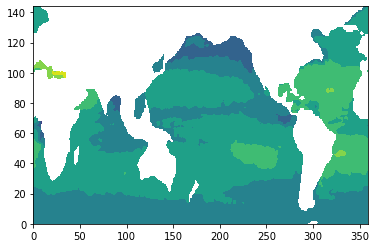

In [8]:
# Go to location of Argo data
os.chdir(argoDir)

# Load in data from main climatology file
# Covers 2004-2018 must be loaded regardless of times chosen
fnArgoMainClimatology = 'RG_ArgoClim_Salinity_2019.nc'
dsTemp = nc.Dataset(fnArgoMainClimatology,'r')
# Lon:360x1 degrees east 20.5- 379.5 1 degree
# Lat:145x1 degrees north -64.5 - 79.5 1 degree
argoLon, argoLat = np.array(dsTemp.variables['LONGITUDE']), np.array(dsTemp.variables['LATITUDE'])
argoPres = np.array(dsTemp.variables['PRESSURE']) # 58x1 dbar +down
argoMonths = np.array(dsTemp.variables['TIME']) # 180 'months since 2004-01-01 00:00:00' '01-JAN-2004 00:00:00'
argoSmean = np.array(dsTemp.variables['ARGO_SALINITY_MEAN']) #(58, 145, 360) Press, Lat, Lon PSS78 -999 fill 'ARGO SALINITY MEAN Jan 2004 - Dec 2018 (15.0 year) RG CLIMATOLOGY'
argoSanom = np.array(dsTemp.variables['ARGO_SALINITY_ANOMALY']) #(180, 58, 145, 360) Time, Press, Lat, Lon PSS78 -999 fill 'ARGO SALINITY ANOMALY defined by Jan 2004 - Dec 2018 (15.0 year) RG CLIMATOLOGY'
#argoBathMask = np.array(dsTemp.variables['BATHYMETRY_MASK']) #(58, 145, 360) Press, Lat, Lon PSS78 -9
#argoMapMask = np.array(dsTemp.variables['MAPPING_MASK']) #(58, 145, 360) Press, Lat,Lon PSS78 -9 'MAPPING MASK: pressure limits of mapping can be shallower than 2000dbar in marginal seas '
dsTemp.close()

# If run year is larger than 2018, also load in data from monthly climatology extensions
endYear = dateList[-1].year
if endYear > 2018:
    # Get list of all unzipped files in directory that are not main climatology
    # One file for each month since end of 2018
    tempFileList = [] # initalize filelist variable
    for (root, dirs, files) in os.walk(argoDir): 
        for filename in sorted(fnmatch.filter(files, 'RG_ArgoClim_2*.nc')): # Get all climatology extention files in directory
            tempFileList.append(filename) # Keep only the filenames
    
    # Load and write data from monthly files to dynamic variables
    for fileLoop in range(len(tempFileList)): # in this case fileLoop has loop count number
        fnTemp = tempFileList[fileLoop] 
        #print (fnTemp)
        dsTemp = nc.Dataset(fnTemp,'r')
        argoMonths = np.concatenate((argoMonths,np.array(dsTemp.variables['TIME'])),axis=0) # 1 'months since 2004-01-01 00:00:00' '01-JAN-2004 00:00:00'
        argoSanom = np.concatenate((argoSanom,np.array(dsTemp.variables['ARGO_SALINITY_ANOMALY'])),axis=0) #((1, 58, 145, 360) Time, Press, Lat, Lon PSS78 -999 fill 'ARGO SALINITY ANOMALY defined by Jan 2004 - Dec 2018 (15.0 year) RG CLIMATOLOGY'
        dsTemp.close()
        del fnTemp
    del tempFileList

# Prepare Argo data for analysis

# Replace fill values -999 with NaN
argoSmean[argoSmean==-999]=np.nan
argoSanom[argoSanom==-999]=np.nan

# Convert climatology time to numpy datetime
# argoMonths is months since 1-Jan-2004
# argoMonths is centered on 15th of month so is given as(0.5, 1.5, 2.5, 3.5 etc.)
# Easiest way to create numpy datenum is to 
# First, add 14 days to Jan-1-2004 so base is 15-Jan-2004
# Second, round down argoTime to closest integer (0,1,2,3, etc.) for use with relativedelta function
argoBaseTime = datetime.strptime('1-1-2004','%m-%d-%Y')+timedelta(days=14)
argoDateTime = np.empty((len(argoMonths),1),dtype='datetime64[s]')
for dateLoop in range(len(argoMonths)): # in this case fileLoop has loop count number
    argoDateTime[dateLoop] = argoBaseTime + relativedelta(months=np.floor(argoMonths[dateLoop]))
del argoBaseTime

# Keep only shallowest pressure level data (2.5db)
tempIndex = np.where(argoPres != np.min(argoPres)) # get indices where not equal to min depth
argoSmean = np.squeeze(np.delete(argoSmean,tempIndex,axis=0))
argoSanom = np.squeeze(np.delete(argoSanom,tempIndex,axis=1))
#argoBathMask = np.squeeze(np.delete(argoBathMask,tempIndex,axis=0))
#argoMapMask = np.squeeze(np.delete(argoMapMask,tempIndex,axis=0))
del tempIndex

# Resize Argo data so dimensions are the same as SMOS and SMAP
#print(np.shape(smosS)) #lon, lat, time
#print(np.shape(smapS)) #lon, lat, time
#print(np.shape(argoSmean)) #lat, lon
#print(np.shape(argoSanom))# time, lat, lon
argoSmean = np.swapaxes(argoSmean, 0, 1)
#argoBathMask = np.swapaxes(argoBathMask, 0, 1)
#argoMapMask = np.swapaxes(argoMapMask, 0, 1)
argoSanom = np.swapaxes(argoSanom, 0, 2)

# Calculate SSS from mean and anomalies
sss_argo = np.empty((len(argoLon),len(argoLat),len(argoDateTime)))

for dateLoop in range(len(argoDateTime)): # in this case fileLoop has loop count number
    sss_argo[:,:,dateLoop] = argoSmean+argoSanom[:,:,dateLoop]

# Standardize Lat - 90 to 90
#print(min(argoLat)) # -64.5 1 degree spacing
#print(max(argoLat)) # 79.5
#print(min(np.diff(argoLat)))
#print(max(np.diff(argoLat)))

# Standardize Lon 0 to 360
#print(min(argoLon)) # 20.5 1 degree spacing
#print(max(argoLon)) # 379.5
#print(min(np.diff(argoLon)))
#print(max(np.diff(argoLon)))

# Adjust longitude values to be 0-360 degrees
tempIndex = np.where(argoLon>360)
argoLon[tempIndex] = argoLon[tempIndex]-360;
del tempIndex

# Sort adjusted longitude values and corresponding Argo salinity data
tempIndex = np.argsort(argoLon);
argoLon = argoLon[tempIndex]
argoSmean = argoSmean[tempIndex,:]
argoSanom = argoSanom[tempIndex,:,:]
#argoBathMask = argoBathMask[tempIndex,:]
#argoMapMask = argoMapMask[tempIndex,:]
sss_argo = sss_argo[tempIndex,:,:]
del tempIndex


# Remove data outside month/year range of run
tempIndex = np.where(argoDateTime < startDate)
argoDateTime=np.delete(argoDateTime,tempIndex,axis=0)
argoSanom = np.delete(argoSanom,tempIndex,axis=2)
sss_argo = np.delete(sss_argo,tempIndex,axis=2)
del tempIndex

tempIndex = np.where(argoDateTime > endDate)
argoDateTime=np.delete(argoDateTime,tempIndex,axis=0)
argoSanom = np.delete(argoSanom,tempIndex,axis=2)
sss_argo = np.delete(sss_argo,tempIndex,axis=2)
del tempIndex

# Quick plot to ensure looks right
tp = plt.contourf(np.transpose(sss_argo[:,:,0]))
plt.show(tp)

# Regrid data to uniform grid

/Users/jesse/opt/anaconda3/envs/pangeo/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/Users/jesse/opt/anaconda3/envs/pangeo/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


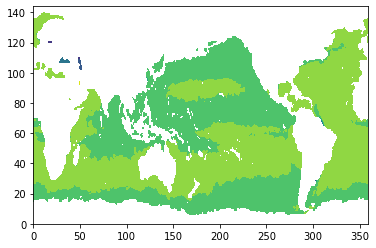

(360, 145, 82)
(360, 145, 82)
(360, 145, 82)


In [9]:
# Put all data on uniform space dimensions
# Argo is coarsest, so use argo lat lon
# Interpolate SMOS and SMAP data onto same spatial resolution as Argo

# Define grids for regridding and create regridder object
smosgrid_in = {'lat': smosLat, 'lon': smosLon} # define input data grid for smos
smapgrid_in = {'lat': smapLat, 'lon': smapLon} # define input data grid for smap
grid_out = {'lat': argoLat, 'lon': argoLon} # define output data grid for smap and smos

#Regrid data
regridderSMOS = xe.Regridder(smosgrid_in, grid_out, 'bilinear')
regridderSMOS

regridderSMAP = xe.Regridder(smapgrid_in, grid_out, 'bilinear')
regridderSMAP

# Use regridder object to regrid data for each time step
sss_smos = np.empty((len(argoLon),len(argoLat),len(argoDateTime))) #preallocate variables
for dateLoop in range(len(dateList)): # in this case fileLoop has loop count number
    tempSMOS = np.squeeze(smosS[:,:,dateLoop])
    sss_smos[:,:,dateLoop] = np.transpose(regridderSMOS(np.transpose(tempSMOS)))
    
sss_smap = np.empty((len(argoLon),len(argoLat),len(argoDateTime))) #preallocate variables
for dateLoop in range(len(dateList)): # in this case fileLoop has loop count number
    tempSMAP = np.squeeze(smapS[:,:,dateLoop])
    sss_smap[:,:,dateLoop] = np.transpose(regridderSMAP(np.transpose(tempSMAP)))
    
# Quick plot to ensure looks right
tp = plt.contourf(np.transpose(sss_smap[:,:,1]))
plt.show(tp)

#sss_argo=sss_argo
print(np.shape(sss_argo))
print(np.shape(sss_smos))
print(np.shape(sss_smap))

# Temporal triple collocation

In [10]:
# Call triple point collocation code for each time step

# Preallocate RMSD variables for speed
rmsd_smos_temporal = np.empty(len(argoDateTime))
rmsd_smos_temporal[:] = np.NaN
rmsd_smap_temporal = np.empty(len(argoDateTime))
rmsd_smap_temporal[:] = np.NaN
rmsd_argo_temporal = np.empty(len(argoDateTime))
rmsd_argo_temporal[:] = np.NaN

# For each month, call basic_triple_point_collocation.m which will return
# domain average RMSD for each dataset for each month
for dateLoop in range(len(dateList)): # in this case fileLoop has loop count number
    #print(np.shape(np.squeeze(sss_smos[:,:,dateLoop])))
    
    [loop_rmsd_smos,loop_rmsd_smap,loop_rmsd_argo]=covariance_triple_point_collocation(np.squeeze(sss_smos[:,:,dateLoop]), \
                                                                                       np.squeeze(sss_smap[:,:,dateLoop]), \
                                                                                       np.squeeze(sss_argo[:,:,dateLoop]), \
                                                                                       excludeLargeDiff)
    rmsd_smos_temporal[dateLoop] = loop_rmsd_smos;
    rmsd_smap_temporal[dateLoop] = loop_rmsd_smap;
    rmsd_argo_temporal[dateLoop] = loop_rmsd_argo;
    del loop_rmsd_smos 
    del loop_rmsd_smap 
    del loop_rmsd_argo

del dateLoop

os.chdir(outputDir)

/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:62: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_d1 = np.nanvar(data1,ddof=1) # Variance computed on flattened variance
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:63: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_d2 = np.nanvar(data2,ddof=1)
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:64: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_d3 = np.nanvar(data3,ddof=1)


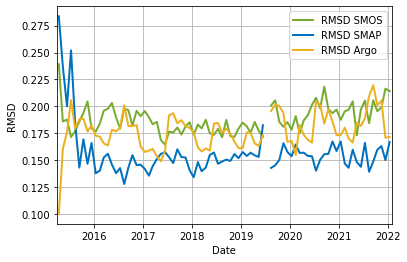

In [11]:
# Plot RMSD for each dataset
plt.plot(argoDateTime,rmsd_smos_temporal, label='RMSD SMOS', color=(0.4660,0.6740,0.1880), linewidth=2)
plt.plot(argoDateTime,rmsd_smap_temporal, label='RMSD SMAP', color=(0,0.4470,0.7410), linewidth=2)
plt.plot(argoDateTime,rmsd_argo_temporal, label='RMSD Argo', color=(0.9290,0.6940,0.1250), linewidth=2)
plt.grid(True)
plt.xlim(startDate,endDate)
plt.xlabel('Date')
plt.ylabel('RMSD')
plt.legend()
plt.show()

# Spatial triple collocation

In [12]:
# Call triple point collocation code for each lat, lon pair for all time steps

# Preallocate RMSD variables for speed
rmsd_smos_spatial = np.empty((len(argoLon),len(argoLat)))
rmsd_smos_spatial[:] = np.NaN
rmsd_smap_spatial = np.empty((len(argoLon),len(argoLat)))
rmsd_smap_spatial[:] = np.NaN
rmsd_argo_spatial = np.empty((len(argoLon),len(argoLat)))
rmsd_argo_spatial[:] = np.NaN

# For each month, call covariance_triple_point_collocation.m which will return
# temporal average RMSD for each dataset for each domain location
for lonLoop in range(len(argoLon)):
    for latLoop in range(len(argoLat)):
        [loop_rmsd_smos,loop_rmsd_smap,loop_rmsd_argo]=covariance_triple_point_collocation(np.squeeze(sss_smos[lonLoop,latLoop,:]), \
                                                                                            np.squeeze(sss_smap[lonLoop,latLoop,:]), \
                                                                                            np.squeeze(sss_argo[lonLoop,latLoop,:]), \
                                                                                            excludeLargeDiff)
        rmsd_smos_spatial[lonLoop, latLoop] = loop_rmsd_smos;
        rmsd_smap_spatial[lonLoop, latLoop] = loop_rmsd_smap;
        rmsd_argo_spatial[lonLoop, latLoop] = loop_rmsd_argo;
        del loop_rmsd_smos 
        del loop_rmsd_smap 
        del loop_rmsd_argo
del lonLoop
del latLoop

os.chdir(outputDir)

/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:62: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_d1 = np.nanvar(data1,ddof=1) # Variance computed on flattened variance
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:63: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_d2 = np.nanvar(data2,ddof=1)
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:64: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_d3 = np.nanvar(data3,ddof=1)
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:91: RuntimeWarning: invalid value encountered in sqrt
  rmsd_d1 = np.sqrt(errorvar_d1);
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:92: RuntimeWarning: invalid value encountered in sqrt
  rmsd_d2 = np.sqrt(errorvar_d2);
/var/folders/5w/_z_sz3116qg9bl1d978q455c0000gn/T/ipykernel_87019/4017683690.py:93: RuntimeWarning: invalid value enco

Text(0.5, 1.0, 'RMSD Argo')

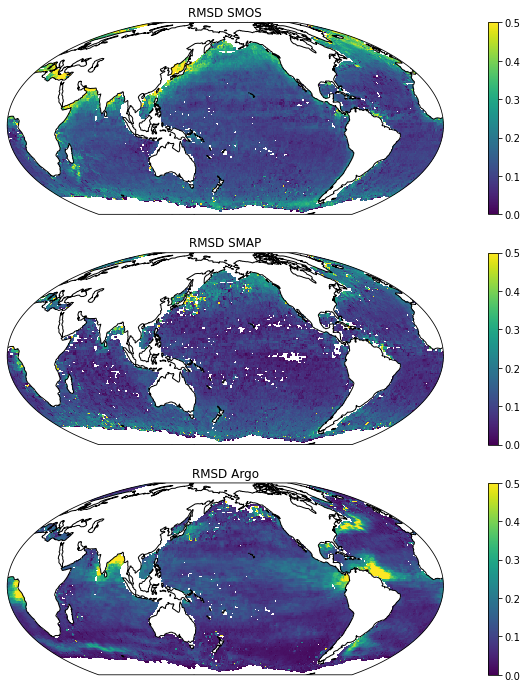

In [13]:
# Plot rmsd for each dataset
fig = plt.figure(figsize=(16, 12))

ax = plt.subplot(3, 1, 1, projection=ccrs.Mollweide(central_longitude=180))
ax.coastlines()
dataplot = ax.pcolor(argoLon, argoLat, np.transpose(rmsd_smos_spatial),transform=ccrs.PlateCarree(),vmin=0, vmax=0.5)
plt.colorbar(dataplot, orientation='vertical')
ax.set_title('RMSD SMOS')

ax2 = plt.subplot(3, 1, 2, projection=ccrs.Mollweide(central_longitude=180))
ax2.coastlines()
dataplot = ax2.pcolor(argoLon, argoLat, np.transpose(rmsd_smap_spatial),transform=ccrs.PlateCarree(),vmin=0, vmax=0.5)
plt.colorbar(dataplot, orientation='vertical')
ax2.set_title('RMSD SMAP')

ax3 = plt.subplot(3, 1, 3, projection=ccrs.Mollweide(central_longitude=180))
ax3.coastlines()
dataplot = ax3.pcolor(argoLon, argoLat, np.transpose(rmsd_argo_spatial),transform=ccrs.PlateCarree(),vmin=0, vmax=0.5)
plt.colorbar(dataplot, orientation='vertical')
ax3.set_title('RMSD Argo')